In [187]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import sys
import tables.group


import macd
import pandas.io.data as web
import matplotlib.pyplot as plt
import multiprocessing as mp
%matplotlib inline
filename='source/deptheth_5.hd5'
path='data/deptheth_r_res.hd5'
print pd.__version__

0.17.1


In [308]:

h5 = pd.HDFStore(filename, 'r')
    
def getGroups(h5):
    groups = {}
    for i in h5.items():
        groups[i[0]]=(i[0],i[1])
    return groups

def getTables(group):
    group=group[1]
    tables={}
    for c in group._v_children:
        tables[c]=group._f_get_child(c)
    return tables

def getIndex(group):
    return getTables(group)['axis1'][:]

def getColumns(group):
    return getTables(group)['axis0'][:]

def getColumn(group,name):
    columns = getColumns(group)
    cidx=0
    while cidx<len(columns) and columns[cidx] != name:
        cidx+=1 
        
    if cidx >= len(columns):
        return None
    
    return getTables(group)['block0_values'][:][:]

def dedupIdx(idx):
    if len(idx) <=0:
        return idx

    idx=idx*1000
    p=idx[0]
    c=0
    for i in range(1,len(idx)):
        idxo=idx[i]
        if idx[i]==p:
            idx[i]+=c
            c+=1
        else:
            c=1
        p=idxo
    return idx
        
def getDataFrame(group):
    idx = getIndex(group)
    #idx=dedupIdx(idx)
    columns = getColumns(group)
    tables= getTables(group)['block0_values']
    dt = pd.DataFrame(tables[:][:],columns=columns,index=idx)
    return dt

def getDataFrames(h5):
    groups =  getGroups(h5)

    keys = sorted(groups.keys())
    dfs={}
    for k in keys:
        df = getDataFrame(groups[k])
        dfs[k]=df
    return dfs
        



        

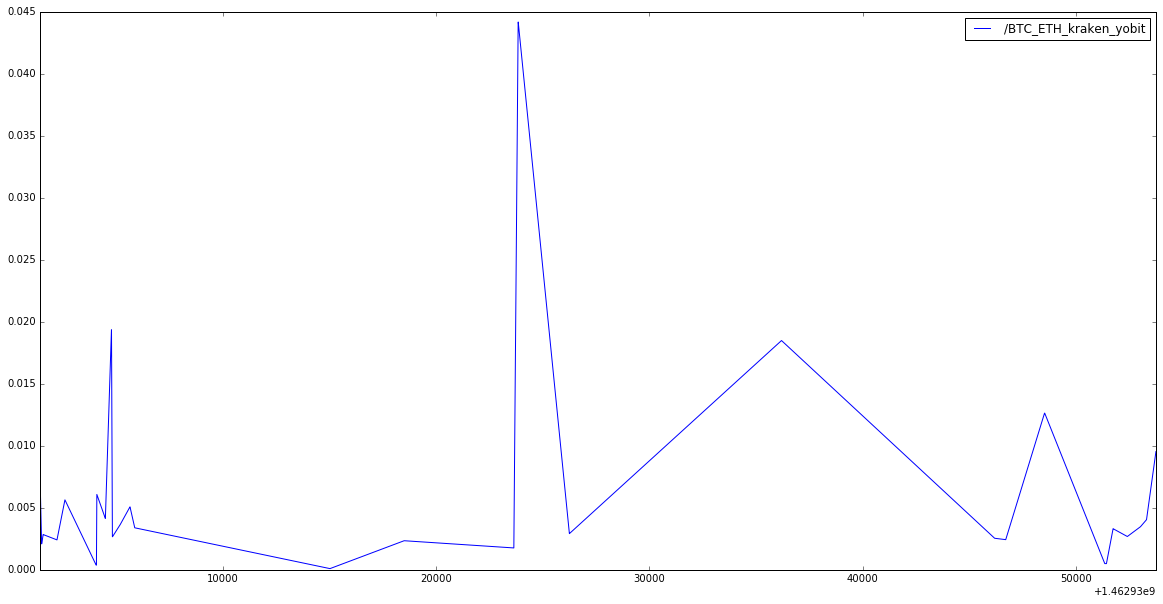

In [319]:
figsize=(20, 10)


dfs=getDataFrames(h5)
for n in dfs.keys()[0:1]:
    df=dfs[n]
    btc=df['profitBtc']
    if btc.max() >2.0:
        continue
    #print n,btc.mean(),btc.max()
    btc.plot(figsize=figsize,label=n,legend=True)
#df['rt2'].plot()


In [318]:
#dfs['/BTC_ETH_bitflyer_bitfinex']['profitBtc'].plot(figsize=figsize)
#dfs['/BTC_ETH_poloniex_kraken']['profitBtc'].plot(figsize=figsize)
#print dfs['/BTC_ETH_poloniex_kraken']['profitBtc']
print dfs['/BTC_ETH_kraken_bleutrade']['profitBtc']

1462954127    0.008883
1462954127    0.008883
1462954128    0.008883
1462954130    0.008883
1462954131    0.008883
1462954131    0.008883
1462954132    0.008883
1462954132    0.008883
1462954133    0.008883
1462954133    0.008883
1462954134    0.008883
1462954134    0.008883
1462954135    0.008883
1462954135    0.008883
1462954136    0.008883
1462954136    0.008883
1462954137    0.008883
1462954137    0.008883
1462954138    0.008883
1462954138    0.008883
1462954139    0.008883
1462954139    0.008883
1462954140    0.008883
1462954140    0.008883
1462954141    0.008883
1462954141    0.008883
1462954142    0.008883
1462954142    0.008883
1462954143    0.008883
1462954143    0.008883
                ...   
1462961477    0.007380
1462961478    0.007380
1462961478    0.007380
1462961479    0.007380
1462961479    0.007380
1462961480    0.007380
1462961480    0.007380
1462961481    0.007380
1462961481    0.007380
1462961482    0.007380
1462961497    0.007393
1462961498    0.007393
1462961498 